# Линейный классификатор SVM (Метод опорных векторов)
Выполните все задания в этом ноутбуке и вспомогательных файлах *.py. Сохраните результат, запакуйте в zip архив и отправьте на почту преподавателю.  
В этом упражнении вам предстоит:  
- реализовать векторизованную функцию потерь (loss) для SVM классификатора; 
- реализовать векторизованную функцию для вычисления аналитического градиента;
- проверить работу функции аналитического градиента, сравнив ее с методом конечных разностей;
- использовать валидационную выборку для настройки скорости обучения (learning rate) и величину регуляризации (regularization strength); 
- найти оптимальные значения весов классификатора с помощью метода градиентного спуска; 
- визуализировать веса классификатора.

In [1]:
!git clone https://github.com/balezz/tad_ml_dl_2021.git


Cloning into 'tad_ml_dl_2021'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 86 (delta 19), reused 64 (delta 5), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [2]:
!cd tad_ml_dl_2021/Assignment2
import os
os.chdir('tad_ml_dl_2021/Assignment2')
os.getcwd()

'/content/tad_ml_dl_2021/Assignment2'

In [3]:

# Подготовка к работе, импорт библиотек
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Изображения нужно отображать в ноутбуке.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Автоматическая перезагрузка модулей из файлов *.py
%load_ext autoreload
%autoreload 2

## Загрузка датасета CIFAR-10 и предварительная подготовка



In [4]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz 

--2021-02-25 03:07:25--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  29.8MB/s    in 6.1s    

2021-02-25 03:07:32 (26.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
!ls

A2.csv		     cifar-10-python.tar.gz  README.MD	       softmax-ru.ipynb
cifar-10-batches-py  lib		     requirements.txt  svm-ru.ipynb


In [6]:
# Путь к папке с данными
cifar10_dir = './cifar-10-batches-py'

# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


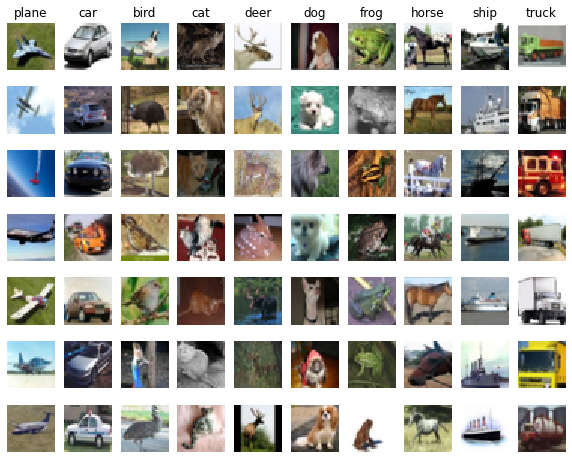

In [7]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Разделим данные на выборки train, val, test

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Для валидации используем подвыборку train
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# На остальных данных из train будем тренировать модель
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Чтобы ускорить разработку, создадим также небольшую dev выборку 
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Для тестирования используем оригинальную выборку test
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [9]:
# Для удобства преобразуем двумерные изображения в одномерные вектора
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


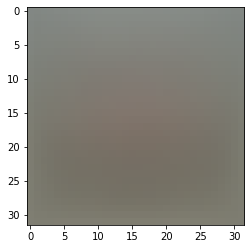

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [10]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Добавим к вектору исходных данных фиктивный признак с постоянным значением 1.
# Этот трюк позволит избежать лишних вычислений: x @ W + b  => x' @ W'
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM классификатор (метод опорных векторов)
Основную работу в этом задании предстоит выполнить в файле classifiers/linear_svm.py  
Часть работы уже выполнена в функции svm_loss_naive. Завершите вычисление градиента в этой функции. В функции svm_loss_vectorized предлагается разработать более эффективную (векторизованную) реализацию.

In [15]:
!git clone https://github.com/KarinaMusina/kavamu

fatal: destination path 'kavamu' already exists and is not an empty directory.


In [16]:
!ls

A2.csv			kavamu	   requirements.txt
cifar-10-batches-py	lib	   softmax-ru.ipynb
cifar-10-python.tar.gz	README.MD  svm-ru.ipynb


In [17]:
os.getcwd()

'/content/tad_ml_dl_2021/Assignment2'

In [18]:
!cd kavamu/Assignment2
import os
os.chdir('kavamu/Assignment2')
os.getcwd()

'/content/tad_ml_dl_2021/Assignment2/kavamu/Assignment2'

In [19]:
# Вычислим loss с помощью наивной реализации функции потерь:
from linear_svm import svm_loss_naive
import time

# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.669598


В текущей реализации градиент функции не вычисляется, возвращаются нули. Реализуйте алгоритм вычисления аналитического градиента в функции svm_loss_naive. Для проверки правильности кода сравните результ вычисления аналитического градиента с методом конечных разностей.

In [20]:
# После реализации вычисления аналитического градиента 
# запустите код в этой ячейке чтобы сравнить результат с методом конечных разностей

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Градиент, вычисленный аналитически и методом конечных разностей должны совпадать
# с точностью до допустимой погрешности вычислений 
from lib.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Сравним градиенты с учетом регуляризации
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 13.282889 analytic: 13.282889, relative error: 6.986531e-12
numerical: 6.977519 analytic: 6.967473, relative error: 7.204612e-04
numerical: 17.990801 analytic: 17.990801, relative error: 1.612927e-11
numerical: 5.958171 analytic: 5.958171, relative error: 1.638119e-11
numerical: -3.118536 analytic: -3.118536, relative error: 6.185821e-11
numerical: 25.529401 analytic: 25.529401, relative error: 3.637199e-12
numerical: -34.309665 analytic: -34.309665, relative error: 1.341160e-12
numerical: 12.539924 analytic: 12.539924, relative error: 1.638246e-11
numerical: 2.007717 analytic: 2.007717, relative error: 1.063040e-10
numerical: 27.739416 analytic: 27.739416, relative error: 2.376808e-12
numerical: -3.408855 analytic: -3.408855, relative error: 2.977368e-11
numerical: -4.321507 analytic: -4.321507, relative error: 2.914902e-11
numerical: -3.085223 analytic: -3.085223, relative error: 1.033486e-10
numerical: 28.035412 analytic: 28.035412, relative error: 1.019925e-11
numerical:

**Вопрос 1**  
Градиент, вычисленный аналитически и методом конечных разностей совпадают неточно. Почему это не считается ошибкой? В какой точке аналитический градиент гарантированно **не совпадет** с методом конечных разностей. Как влияет добавление смещения (отступ, margin) на вычисление функции потерь. Подсказка: loss строго говоря не дифференцируемая функция.  
$\color{blue}{\textit Ответ:}$   
loss = max(0, x) строго говоря не дифференциируемая функция, т.к. для max (x, y) и x = y градиент не определен, функция не дифференциируема; иными словами, в точке 0 в данном случае будет гарантированный разрыв в силу недифференциируемости функции. 
Добавление смещения также может повлиять на вычисление функции потерь: если x = -1e-7, а h= 1e-5, то max (0, x) = 0, аналитический градиент равен 0, но числовой градиент по функции max (0, x + h) будет отличаться от нулевого значения. 
Неточность совпадения градиентов не считается ошибкой, так как в переделе все равно стремится к 0.

In [21]:
# Теперь реализуйте векторизованное вычисление функции потерь.
# Для прохождения теста в этой ячейке градиент вычислять необязательно.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Значения потерь должны совпадать, но векторизованная реализация должна вычисляться быстрее
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.669598e+00 computed in 0.126781s
Vectorized loss: 8.669598e+00 computed in 0.009971s
difference: -0.000000


In [22]:
# Реализуйте вычисление аналитического градиента dW в функции svm_loss_vectorized

# Градиенты должны совпадать, но векторизованная реализация должна вычисляться быстрее
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# Для вычисления расстояния между двумя матрицами градиентов используем норму Фробениуса
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.127368s
Vectorized loss and gradient: computed in 0.008323s
difference: 0.000000


## Стохастический градиентный спуск
Мы уже реализовали эффективное вычисление функции потерь и градиента весов. Теперь мы готовы к минимизации потерь методом стохастического градиентного спуска. Реализуйте метод в файле lib/classifiers/linear_classifier.py

In [23]:
# Реализуйте SGD и проверьте результат 
from linear_classifier1 import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 791.400328
iteration 100 / 1500: loss 287.771934
iteration 200 / 1500: loss 108.311389
iteration 300 / 1500: loss 42.726086
iteration 400 / 1500: loss 19.350294
iteration 500 / 1500: loss 10.365310
iteration 600 / 1500: loss 7.081305
iteration 700 / 1500: loss 6.304596
iteration 800 / 1500: loss 5.294153
iteration 900 / 1500: loss 5.112725
iteration 1000 / 1500: loss 5.314010
iteration 1100 / 1500: loss 5.317634
iteration 1200 / 1500: loss 5.355583
iteration 1300 / 1500: loss 5.046098
iteration 1400 / 1500: loss 5.549070
That took 10.101803s


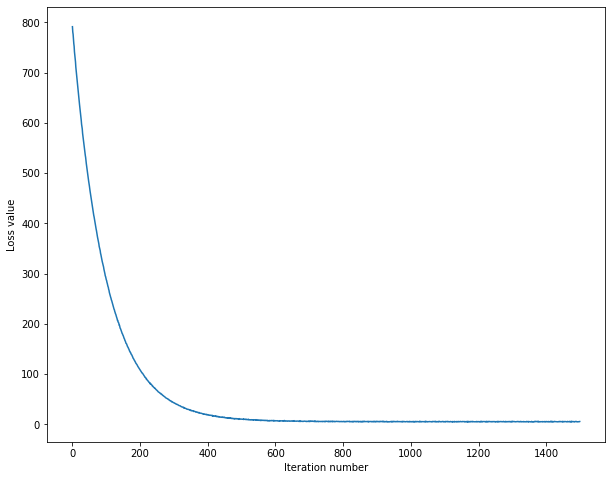

In [24]:
# Построим график зависимости функции потерь от количества итераций
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [25]:
# Реализуйте функцию LinearSVM.predict и оцените точность предсказания 
# на выборках train и val
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371673
validation accuracy: 0.380000


In [32]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.39 на выборке val.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (training_accuracy, validation_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
results = {}
best_val = -1   
best_svm = None # Лучший экземпляр LinearSVM 

################################################################################
# TODO:                                                                        #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на val       #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор SVM     #
# на train выборке, вычислите точность на выборках train, val и сохраните      #
# результат в словарь results. Лучшее значение точности сохраните в best_val   #
# лучший классификатор - в best_svm                                            #
#                                                                              #
# Подсказка: чтобы уменьшить время обучения, используйте dev подвыборку.       #
# После того, как код будет реализован и отлажен, замените dev на train.       #
################################################################################

# Пример допустимых значений. Можете изменить на свое усмотрение.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]

for lr, rg in grid_search:
    # Create a new SVM instance
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=554, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Вывод результатов.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/tad_ml_dl_2021/Assignment2/kavamu/Assignment2/linear_svm.py:94: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/tad_ml_dl_2021/Assignment2/kavamu/Assignment2/linear_svm.py:94: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/content/tad_ml_dl_2021/Assignment2/kavamu/Assignment2/linear_svm.py:117: RuntimeWarning: overflow encountered in multiply
  dW = dW + reg * 2 * W


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.363918 val accuracy: 0.391000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.356347 val accuracy: 0.375000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.082224 val accuracy: 0.095000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.391000


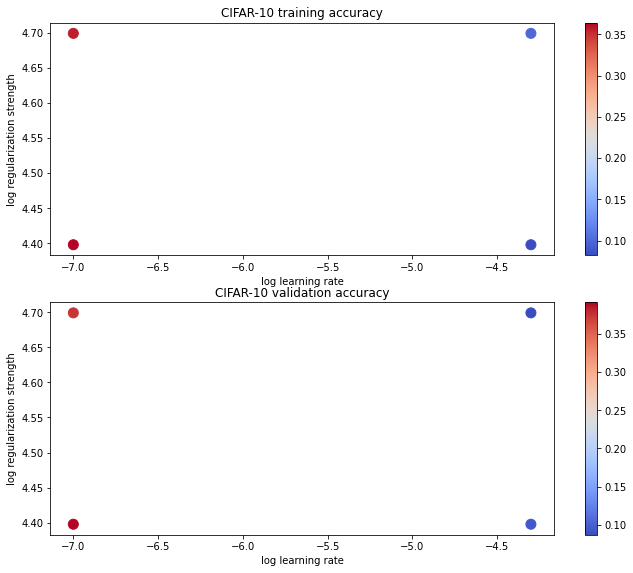

In [33]:
# Визуализируем результаты кросс-валидации
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# график accuracy на обучении
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# график accuracy на валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [34]:
# Лучший классификатор на тестовых данных
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


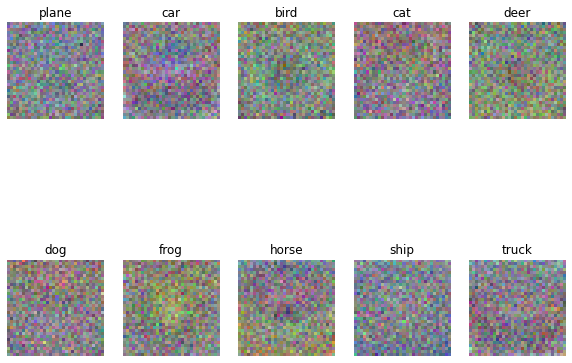

In [35]:
# Визуализируем веса W для каждого класса
w = best_svm.W[:-1,:] # отбросим bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Вопрос 2**  
Опишите, на что похожи веса классификатора SVM. Почему они так выглядят?   
$\color{blue}{\textit Ответ:}$ 
Веса похожи на комбинации изображений по классам

---
# ПОЗДРАВЛЯЕМ!

Это конец задания. Не забудьте сохранить этот ноутбук и файлы linear_svm.py и linear_classifier.py